# Classification with SVM on the IBM QASM Simulator
## Circuit SVM Code

## Import Packages

In [1]:
import numpy as np
import glob
from utils_updated import *
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn import preprocessing
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from qiskit import BasicAer, IBMQ
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import QSVM
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name


## Load the training and test sets

X_train (50, 8)
Y_train (50,)
X_test (250000, 8)
Y_test (250000,)


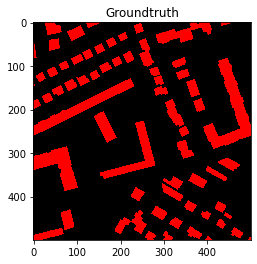

In [2]:
# Load training set
key='_tiny'
X_train=np.load('X_train_tile_4'+key+'.npy')
Y_train=np.load('Y_train_tile_4'+key+'.npy')

print('X_train',X_train.shape) 
print('Y_train',Y_train.shape) 

# Load test set
X_test=np.load('X_test_tile_8_subregion.npy')
Y_test=np.load('Y_test_tile_8_subregion.npy')

print('X_test',X_test.shape) 
print('Y_test',Y_test.shape) 

# If {-1,1} is required:
# Y_train=np.where(Y_train==0,-1,Y_train)

groundtruth=np.reshape(Y_test,(500,500))
plt.title('Groundtruth')
cmap = colors.ListedColormap(['black', 'red'])
plt.rcParams["figure.figsize"] = (5,5)
view=plt.imshow(groundtruth,cmap=cmap)


## Option 1: selected a NxN window as test set
This training set has shown the best results.

(225, 8) (225,)


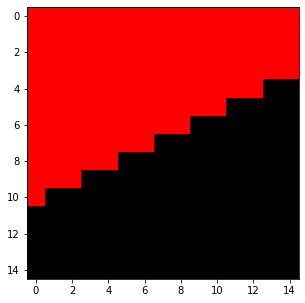

In [3]:
N=15
start=251
X_test2 = np.reshape(X_test,(500,500,8))
X_test2 = X_test2[start:start+N,0:N]
Y_test2 = groundtruth[start:start+N,0:N]
plt.imshow(Y_test2, cmap=cmap)
X_test2 = np.reshape(X_test2, (N*N,8))
Y_test2 = np.squeeze(np.reshape(Y_test2, (N*N,1)))
print(X_test2.shape,Y_test2.shape)

## Option 2: select N random pixels as test set

In [ ]:
N=100
#random_indices = np.random.choice(X_test.shape[0],size=N,replace=False)
X_test_0_indices = [i for i, y in enumerate(Y_test) if y == 0]
X_test_1_indices = [i for i, y in enumerate(Y_test) if y == 1]

random_indices_0 = np.random.choice(len(X_test_0_indices),size=N,replace=False)
random_indices_1 = np.random.choice(len(X_test_1_indices),size=N,replace=False)
#print(random_indices_0,random_indices_1)
#print(np.take(X_test_0_indices, random_indices_0))
X_test2 = np.append(X_test[np.take(X_test_0_indices, random_indices_0),:], X_test[np.take(X_test_1_indices, random_indices_1),:], axis=0)
Y_test2 = np.append(Y_test[np.take(X_test_0_indices, random_indices_0)], Y_test[np.take(X_test_1_indices, random_indices_1)])
#print(X_test2,Y_test2)

## Quantum enhanced SVM (circuit based)

The `'TOKEN'` string can be copied from the personal IBM Quantum Experience account.

In [4]:
token='TOKEN'
#IBMQ.save_account(token)
provider = IBMQ.load_account()

Block for dimensionality reduction. `feature_dim = 8` keeps the samples unchanged.

In [5]:
from sklearn.decomposition import PCA

feature_dim = 8
pca = PCA(feature_dim)
X_train = pca.fit_transform(X_train)
X_test = pca.fit_transform(X_test)
X_test2 = pca.fit_transform(X_test2)

Block for training dataset creation.

In [6]:
X_train_0_indices = [i for i, y in enumerate(Y_train) if y == 0]
X_train_1_indices = [i for i, y in enumerate(Y_train) if y == 1]
training_input = {'0': X_train[X_train_0_indices], '1': X_train[X_train_1_indices]}

The QSVM function needs a test dataset and a prediction dataset. Since for the test dataset only the accuracy is computed, and we need a plot of the results, we use the sub-image as a prediction dataset and keep only a small number of samples for the test dataset to lower the time overhead.

In [7]:
X_test_0_indices = [i for i, y in enumerate(Y_test) if y == 0]
X_test_1_indices = [i for i, y in enumerate(Y_test) if y == 1]
number_test_samples = 20
X_test_0_indices = X_test_0_indices[0:number_test_samples]
X_test_1_indices = X_test_1_indices[0:number_test_samples]
test_input = {'0': X_test[X_test_0_indices], '1': X_test[X_test_1_indices]}
class_labels = [0,1]
datapoints = [X_test2, Y_test2]

Block for circuit creation.

In [14]:
from functools import reduce
def linear_feature_map(x: np.ndarray) -> float:
    coeff = x[0] if len(x) == 1 else reduce(lambda m, n: m*n, x)
    return coeff
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, data_map_func=linear_feature_map, entanglement='linear')

## Run QSVM

In [16]:
seed = 1000
qsvm = QSVM(feature_map, training_input, test_input, datapoints[0])
backend = provider.get_backend('ibmq_qasm_simulator')
#backend = provider.get_backend('ibmq_16_melbourne')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)
#quantum_instance = QuantumInstance(backend, shots=1024)
result = qsvm.run(quantum_instance)

The results for the given test set and datapoints are shown in the following:

Testing success ratio: 0.525
Prediction from datapoints set:
  success rate: 51.55555555555556%
  F1 score: 0.441025641025641
  Accuracy: 0.5155555555555555


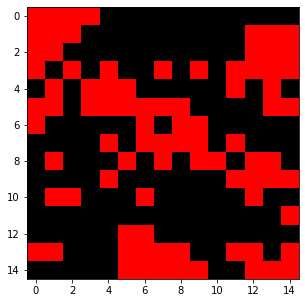

In [17]:
print(f'Testing success ratio: {result["testing_accuracy"]}')
print('Prediction from datapoints set:')
#print(f'  ground truth: {map_label_to_class_name(datapoints[1], qsvm.label_to_class)}')
#print(f'  prediction:   {result["predicted_classes"]}')
predicted_labels = result["predicted_labels"]
print(f'  success rate: {100*np.count_nonzero(predicted_labels == datapoints[1])/len(predicted_labels)}%')
print(f'  F1 score: {f1_score(datapoints[1], result["predicted_labels"])}')
print(f'  Accuracy: {accuracy_score(datapoints[1], result["predicted_labels"])}')
classification_map=np.reshape(result["predicted_labels"],(N,N))
plt.imshow(classification_map, cmap=cmap)

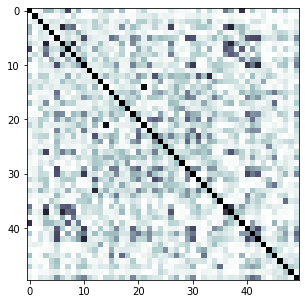

In [18]:
kernel_matrix = result['kernel_matrix_training']
plt.imshow(np.asmatrix(kernel_matrix),interpolation='nearest',origin='upper',cmap='bone_r');

In [19]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright